# Loading and Preprocessing Data with TensorFlow

The *Data API* availabe from TensorFlow makes handling large data sets that don't fit into RAM much easier. In general, a dataset object is created and told where to find files. It then manages the rest of the implementation details including multithreading, queueing, batching, and prefetching.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
from tensorflow import keras
from pathlib import Path

%matplotlib inline
np.random.seed(0)
plt.style.use('seaborn-whitegrid')
assets_dir = Path('assets', 'ch13')

## The Data API

The Data API is centered around the concept of a *dataset*, a sequence of data items.
For simplicity, the first example below shows a dataset held in memory created using `from_tensor_slices()`.
It is an iterable.

In [2]:
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

In [3]:
for t in dataset:
    print(t)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


### Chaining transformations

The dataset object has many transformation methods that return new datasets, making it easy to chain the methods.

In [4]:
dataset = dataset.repeat(3).batch(7)
for t in dataset:
    print(t)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


Alternatively, `map()` can be used to apply custom transformations.

In [5]:
dataset = dataset.map(lambda x: x * 2)

The `apply()` method applies a function to the dataset as a whole, not each item individually.
The following example removes the batches created above.

In [6]:
dataset = dataset.apply(tf.data.experimental.unbatch())

Instructions for updating:
Use `tf.data.Dataset.unbatch()`.


The `filter()` method makes it each to apply a filter to each data point.

In [7]:
dataset = dataset.filter(lambda x: x < 10)

The `take()` method can be used to look at just a few data points.

In [8]:
for t in dataset.take(3):
    print(t)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


### Shuffling the data

The shuffling method uses a buffer in memory to prepare data points before they are used and then randomly pulls one to be used when requested.
The size of the buffer must be declared so that all of the RAM is not consumed, but it also a bottleneck on how well the data will be shuffled.

In [9]:
dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size=5, seed=0).batch(7)
for t in dataset:
    print(t)

tf.Tensor([2 1 5 0 7 6 0], shape=(7,), dtype=int64)
tf.Tensor([4 3 9 8 2 3 4], shape=(7,), dtype=int64)
tf.Tensor([8 6 0 7 2 3 9], shape=(7,), dtype=int64)
tf.Tensor([5 1 4 1 5 9 6], shape=(7,), dtype=int64)
tf.Tensor([7 8], shape=(2,), dtype=int64)


One solution to the limits of `shuffle()` is to pre-shuffle the data.
For example, the `shuf` command in Linux shuffles the lines of a file.
Still, we will want to shuffle the file on each epoch.
To shuffle the data further, it is common the split the data into multiple files and then read in data from them randomly simultaneously, interleaving their records.
This method, paired with `shuffle()`, is usually a great way to shuffle the data and is easily accomplished with the Data API.

For this example, I split the housing data into 10 files.

In [10]:
from sklearn.datasets import fetch_california_housing

cal_housing = fetch_california_housing()
df = pd.DataFrame(cal_housing.data)
df.columns = cal_housing.feature_names
df['MedianHousingValue'] = cal_housing.target
df = df.sample(frac=1)
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHousingValue
14740,4.1518,22.0,5.663073,1.075472,1551.0,4.180593,32.58,-117.05,1.369
10101,5.7796,32.0,6.107226,0.927739,1296.0,3.020979,33.92,-117.97,2.413
20566,4.3487,29.0,5.930712,1.026217,1554.0,2.910112,38.65,-121.84,2.007
2670,2.4511,37.0,4.992958,1.316901,390.0,2.746479,33.20,-115.60,0.725
15709,5.0049,25.0,4.319261,1.039578,649.0,1.712401,37.79,-122.43,4.600
...,...,...,...,...,...,...,...,...,...
13123,4.4125,20.0,6.000000,1.045662,712.0,3.251142,38.27,-121.26,1.446
19648,2.9135,27.0,5.349282,0.933014,647.0,3.095694,37.48,-120.89,1.594
9845,3.1977,31.0,3.641221,0.941476,704.0,1.791349,36.58,-121.90,2.893
10799,5.6315,34.0,4.540598,1.064103,1052.0,2.247863,33.62,-117.93,4.846


In [11]:
cal_housing_files = []
for i, split_df in enumerate(np.split(df, 10)):
    file_path = assets_dir.joinpath('ca_housing_' + str(i) + '.csv')
    cal_housing_files.append(file_path)
    split_df.to_csv(file_path, index=False)

In [12]:
cal_housing_files

[PosixPath('assets/ch13/ca_housing_0.csv'),
 PosixPath('assets/ch13/ca_housing_1.csv'),
 PosixPath('assets/ch13/ca_housing_2.csv'),
 PosixPath('assets/ch13/ca_housing_3.csv'),
 PosixPath('assets/ch13/ca_housing_4.csv'),
 PosixPath('assets/ch13/ca_housing_5.csv'),
 PosixPath('assets/ch13/ca_housing_6.csv'),
 PosixPath('assets/ch13/ca_housing_7.csv'),
 PosixPath('assets/ch13/ca_housing_8.csv'),
 PosixPath('assets/ch13/ca_housing_9.csv')]

Now we can create a dataset object and point to all three of the files.
Alternatively, we could pass a pattern such as `'assets/ch13/ca_housing_*.csv'`.

In [13]:
cal_housing_strs = [x.as_posix() for x in cal_housing_files]
filepath_dataset = tf.data.Dataset.list_files(cal_housing_strs, seed=0)

Then the `interleave()` function can pull randomly from the files.
Make sure to skip the first row since it contains the headers.

In [14]:
dataset = filepath_dataset.interleave(
    lambda fp: tf.data.TextLineDataset(fp).skip(1)
)

In [15]:
for line in dataset.take(5):
    print(line.numpy())

b'4.2386,6.0,7.723076923076923,1.1692307692307693,228.0,3.5076923076923077,33.83,-117.55,5.00001'
b'4.1518,22.0,5.663072776280323,1.0754716981132075,1551.0,4.180592991913747,32.58,-117.05,1.369'
b'3.125,16.0,5.380070546737214,1.0582010582010581,3407.0,3.004409171075838,36.8,-119.83,0.808'
b'3.2875,52.0,5.990936555891238,1.039274924471299,887.0,2.6797583081570995,34.07,-118.15,2.344'
b'4.3898,52.0,5.32662192393736,1.1006711409395973,1485.0,3.3221476510067114,37.73,-122.44,2.7'


Note that the data are still byte strings that need to be processed further, still.

### Preprocessing the data

We can write a function to preprocess this input data.
This implementation assumes we have precomputed the mean and standard deviation for each column.

The first step is to define defaults and use those to help decode the byte string using `tf.io.decode_csv()`.
Then `x` and `y` are made as as stacks of the list of 1D tensors, one per column, returned from the previous step.
Finally,  the z-scaled data points and the target values are returned.

In [16]:
n_inputs = 8
X_mean = df.mean().tolist()[:n_inputs]
X_std = df.std().tolist()[:n_inputs]

def preprocess(line):
    defs = [0.0] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

In [17]:
preprocess(b'8.3252,41.0,6.984126984126984,1.0238095238095237,322.0,2.5555555555555554,37.88,-122.23,4.526')

(<tf.Tensor: id=187, shape=(8,), dtype=float32, numpy=
 array([ 2.344709  ,  0.98211884,  0.6285442 , -0.15375382, -0.97440493,
        -0.04959533,  1.0525227 , -1.3278059 ], dtype=float32)>,
 <tf.Tensor: id=183, shape=(1,), dtype=float32, numpy=array([4.526], dtype=float32)>)

Finally, we can create one function to wrap all of these steps into one.

In [18]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths)
    dataset = dataset.interleave(
        lambda fp: tf.data.TextLineDataset(fp).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads
    )
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size).repeat(repeat)
    return dataset.batch(batch_size).prefetch(1)

### Prefetching

The `prefecth(1)` included at the end of `csv_reader_dataset()` ensures that the next batch is ready to be used when the current training step is completed.

### Using the dataset with tf.keras

The dataset we have built can be used directly by Keras.

In [19]:
train_set = csv_reader_dataset(cal_housing_strs[:5])
valid_set = csv_reader_dataset(cal_housing_strs[5:8])
test_set = csv_reader_dataset(cal_housing_strs[8:])

In [20]:
model = keras.models.Sequential([
    keras.layers.InputLayer(n_inputs),
    keras.layers.Dense(20, activation='relu', kernel_initializer='he_normal',
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal',
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(5, activation='relu', kernel_initializer='he_normal',
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(1),
])

model.compile(optimizer=keras.optimizers.Nadam(),
              loss='mse')

history = model.fit(train_set, epochs=10, validation_data=valid_set)

Epoch 1/10
323/323 [==============================] - 9s 29ms/step - loss: 3.5360 - val_loss: 0.0000e+00
Epoch 2/10
323/323 [==============================] - 3s 10ms/step - loss: 1.4575 - val_loss: 1.2450
Epoch 3/10
323/323 [==============================] - 3s 10ms/step - loss: 1.1931 - val_loss: 1.0837
Epoch 4/10
323/323 [==============================] - 3s 11ms/step - loss: 1.0586 - val_loss: 0.9823
Epoch 5/10
323/323 [==============================] - 3s 10ms/step - loss: 0.9664 - val_loss: 0.8965
Epoch 6/10
323/323 [==============================] - 4s 11ms/step - loss: 0.8677 - val_loss: 0.8424
Epoch 7/10
323/323 [==============================] - 4s 13ms/step - loss: 0.8584 - val_loss: 0.7994
Epoch 8/10
323/323 [==============================] - 4s 12ms/step - loss: 0.7863 - val_loss: 0.7590
Epoch 9/10
323/323 [==============================] - 4s 12ms/step - loss: 0.7503 - val_loss: 0.7244
Epoch 10/10
323/323 [==============================] - 4s 13ms/step - loss: 0.7292 - va

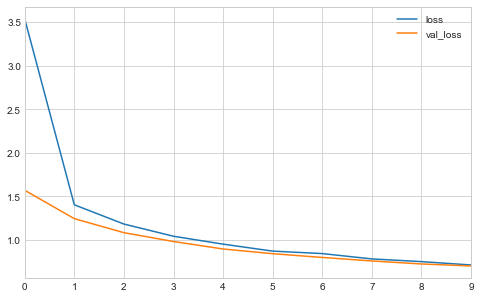

In [21]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.show()

In [22]:
model.evaluate(test_set)

129/129 [==============================] - 1s 11ms/step - loss: 0.6722


0.6722136361654415

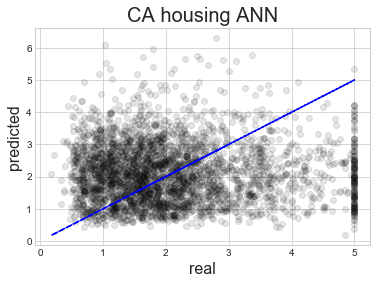

In [23]:
new_data = test_set.take(100)
y_new = []
for __, y in new_data:
    y_new.append(y.numpy())

y_new = np.concatenate(y_new).flatten()

y_pred = model.predict(new_data.map(lambda X, y: X)).flatten()

fig, ax = plt.subplots()
ax.scatter(y_new, y_pred, color='k', alpha=0.1)
ax.plot(y_new, y_new, 'k--', color='blue')
ax.set_title('CA housing ANN', fontsize=20)
ax.set_xlabel('real', fontsize=16)
ax.set_ylabel('predicted', fontsize=16)
plt.show()

In [24]:
np.corrcoef(y_new, y_pred)[0, 1]

-0.001153286649125252

In [25]:
idx = y_new < 5
np.corrcoef(y_new[idx], y_pred[idx])[0, 1]

0.010225436674531687

## Preprocessing the input features

There are 3 general methods for preprocessing data: 1) preparing ahead of time using NumPy, Pandas, Scikit-Learn, etc., 2) on the fly using the Data API and mapping over the instances (see above), or 3) including a preprocessing layer in the model.
We will experiment with the third option below.

The simplest implementation would be to use s `Lambda` layer.
The following example applies scaling to the input data.

In [26]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    random_state=0)

means = np.mean(X_train, axis=0, keepdims=True)
stds = np.std(X_train, axis=0, keepdims=True)
eps = 0.001

model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: (x - means) / (stds + eps)),
    keras.layers.Dense(10, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dense(5, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(optmizer=keras.optimizers.Nadam(0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                    epochs=200, 
                    validation_split=0.2,
                    callbacks=[
                        keras.callbacks.EarlyStopping(min_delta=0.0, patience=5)
                    ],
                    verbose=0)

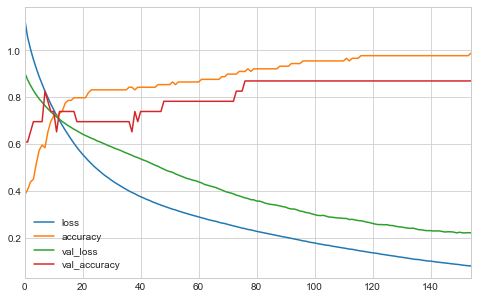

In [27]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.show()

In [28]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f'loss: {loss:.2f}; accuracy: {accuracy:.2f}')

loss: 0.11; accuracy: 0.97


In [29]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'loss: {loss:.2f}; accuracy: {accuracy:.2f}')

loss: 0.20; accuracy: 0.92


Alternatively, you can create a separate layer class that can retain other data.
This is preferable to using global variables like above with `means` and `stds`.

In [30]:
class StandardizationLayer(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
        return
    
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())

Before this layer can be used, it must be "adapted" by passing in the training data.
Now the feature means and standard deviations are contained within the layer.

In [31]:
std_layer = StandardizationLayer(X_train)

### Encoding categorical features using one-hot vectors

NN's can only take numeric inputs.
Thus, categorical inputs must be encoded and one common method is *one-hot-vectors*.

For example, we can encode the ocean proximity feature from the CA housing data.
We need a list of the possible categories and their indices.
Then, a `KeyValueTensorInitializer` is created from these two lists.
Finally, a `StaticVocabularyTable` is created from the initializer.

The `num_oov_buckets` is the number of *out-of-vocabulary* that could be in the data, but not reported during initialization.
If a category comes in that wasn't in the original "vocabulary" of the table, it will be hashed and assigned to one of the oov buckets.
The more unknown categoires you expect to find, the move oov buckets you must add.
If there are not enough oov buckets, then multiple categories could be mushed into one bucket.

In [32]:
vocab = ['1<H OCEAN', 'INLAND', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND']
indices = tf.range(len(vocab), dtype=tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocab, indices)
num_oov_buckets = 2
table = tf.lookup.StaticVocabularyTable(table_init, num_oov_buckets)

Now we can use the lookup table to encode an example batch of categorical features to one-hot vectors.
"DESERT" was not included in the original vocab, so it should be assigned to one of the oov buckets.

In [33]:
eg_categories = tf.constant(['NEAR BAY', 'DESERT', 'INLAND', 'NEAR OCEAN'])
cat_indices = table.lookup(eg_categories)
cat_indices

<tf.Tensor: id=17006, shape=(4,), dtype=int64, numpy=array([3, 5, 1, 2])>

In [34]:
cat_one_hot = tf.one_hot(cat_indices, depth=len(vocab) + num_oov_buckets)
cat_one_hot

<tf.Tensor: id=17010, shape=(4, 7), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.]], dtype=float32)>

It would be possible to wrap up this process into a custom layer, though Keras may add a layer called `TextVectorization` in the future to do the same thing.

One-hot vectorization is fine for a few categories, but if the vocabulary is too large, a more efficient method is to use *embeddings* instead.

### Encoding categorical features using embedding

"An embedding is a trainable dense vector that represents a category."
Basically, an N-dimensional space is created and each word is assigned a vector.
This vector is adjusted during training such that like words become closer and unlike words get further apart.
In more sophisticated models, such as *word2vec*, the space can become even more sophisticated and actually embed the meanings of the words.
This is called *representation learning*.

First, below, we will manually create an embedding matrix as a demonstration.
Then we will create an `Embedding` layer available from Keras to show how this would be used in practice.

In [35]:
# Create a 2D embedding of the features.
embedding_dims = 2

# Initialize the vectors for each vocabulary term randomly.
embed_init = tf.random.uniform([len(vocab) + num_oov_buckets, embedding_dims])
embedding_matrix = tf.Variable(embed_init)
embedding_matrix

<tf.Variable 'Variable:0' shape=(7, 2) dtype=float32, numpy=
array([[0.6443517 , 0.8595996 ],
       [0.6088693 , 0.47989762],
       [0.04883015, 0.02534735],
       [0.99182963, 0.19231832],
       [0.67552006, 0.02664173],
       [0.3988006 , 0.554453  ],
       [0.3432995 , 0.25060523]], dtype=float32)>

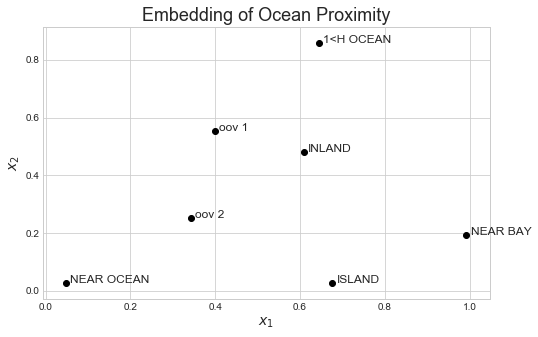

In [36]:
names = vocab + ['oov 1', 'oov 2']
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(embedding_matrix[:, 0], embedding_matrix[:, 1], color='k')
ax.set_xlabel('$x_1$', fontsize=14)
ax.set_ylabel('$x_2$', fontsize=14)
ax.set_title('Embedding of Ocean Proximity', fontsize=18)

for i, name in enumerate(names):
    x, y = embedding_matrix[i, 0].numpy() + 0.01, embedding_matrix[i, 1].numpy()
    ax.annotate(name, (x, y), fontsize=12)

plt.show()

In [37]:
# Encode an example batch.
eg_categories = tf.constant(['NEAR BAY', 'DESERT', 'INLAND', 'NEAR OCEAN'])
cat_indices = table.lookup(eg_categories)
cat_indices
tf.nn.embedding_lookup(embedding_matrix, cat_indices)

<tf.Tensor: id=17136, shape=(4, 2), dtype=float32, numpy=
array([[0.99182963, 0.19231832],
       [0.3988006 , 0.554453  ],
       [0.6088693 , 0.47989762],
       [0.04883015, 0.02534735]], dtype=float32)>

Below is a model (built using the functional API) that can process categorical features and learn an embedding for each category.

In [38]:
# Standard numerical inputs.
regular_inputs = keras.layers.Input(shape=[8])

# Categorical inputs.
categories = keras.layers.Input(shape=[], dtype=tf.string)
cat_indices = keras.layers.Lambda(lambda cats: table.lookup(cats))(categories)
cat_embed = keras.layers.Embedding(input_dim=6, output_dim=2)(cat_indices)

# Combine the inputs.
encoded_inputs = keras.layers.concatenate([regular_inputs, cat_embed])

# Hidden layers.
hidden_layer1 = keras.layers.Dense(
    15, 
    activation='elu', 
    kernel_initializer='he_normal'
)(encoded_inputs)

hidden_layer2 = keras.layers.Dense(
    10, 
    activation='elu', 
    kernel_initializer='he_normal'
)(hidden_layer1)

hidden_layer3 = keras.layers.Dense(
    5, 
    activation='elu', 
    kernel_initializer='he_normal'
)(hidden_layer2)

# Output layer.
outputs = keras.layers.Dense(1)(hidden_layer3)

# Model.
model = keras.models.Model(inputs=[regular_inputs, categories],
                           outputs=[outputs])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None,)              0           input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 2)            12          lambda_1[0][0]                   
______________________________________________________________________________________________

### Keras preprocessing layers

These are currently under development by the TF team and should be available soon.
They generally follow the process used above where a layer is created, its adapt method is called with a data sample, and then it is inserted into the model.

Preprocessing for a deployed model is difficult and can require the duplication of code in multiple locations (ie. into TensorFlow.js for use in the browser).
This break with DRY can be avoided by using the TF Transform library from TF Extended (TFX).

## The TensorFlow Datasets (TFDS) project

TFDS is an easy way to download common image, text, audio, and video datasets.

In [39]:
import tensorflow_datasets as tfds

dataset = tfds.load(name='mnist')
mnist_train, mnist_test = dataset['train'], dataset['test']

mnist_train = mnist_train.shuffle(10000).batch(32).prefetch(1)

Each training instance contains the image and label.

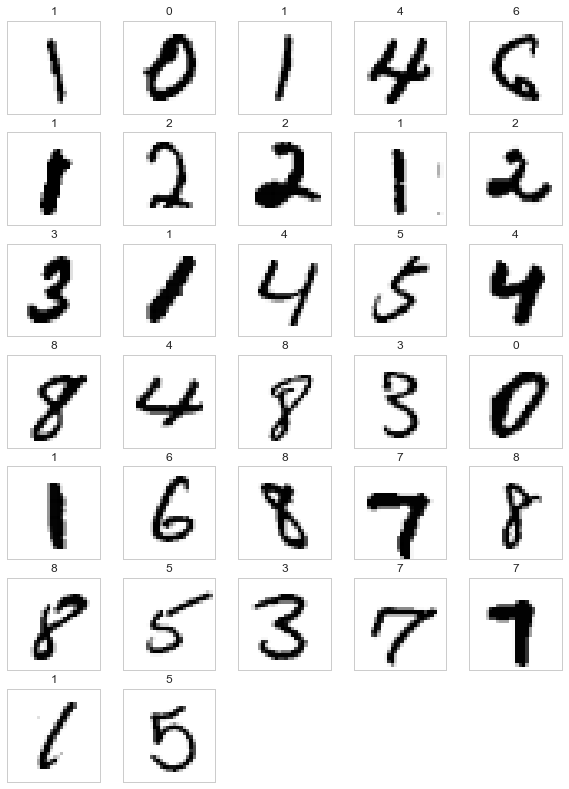

In [40]:
from math import ceil


def plot_image(img, ax):
    ax.imshow(img.numpy().reshape(28, -1))
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    return None


def plot_images(imgs, lbls):
    
    n_col = 5
    n_row = ceil(len(lbls) / n_col)
    fig = plt.figure(figsize=(2 * n_col, 2 * n_row))
    
    for i, (img, lbl) in enumerate(zip(imgs, lbls)):
        ax = plt.subplot(n_row, n_col, i+1)
        plot_image(img, ax)
        ax.set_title(lbl.numpy())
    

# Plot a sample of the MNIST data.
for item in mnist_train.take(1):
    images = item['image']
    labels = item['label']

plot_images(images, labels)
    
plt.show()

However, the neural network model's `fit()` method requires a tuple of images and a tuple of labels.
It would be possible to extract these data into separate tuples using the `map()` function from Numpy, though it is simpler to ask the `load()` function from TFDS to do this by setting `as_supervised=True`.

In [41]:
dataset = tfds.load(name='mnist', batch_size=32, as_supervised=True)
mnist_train = dataset['train'].prefetch(1)

def make_hidden_layer(n_neurons):
    return keras.layers.Dense(n_neurons, 
                              activation='elu', 
                              kernel_initializer='he_normal', 
                              kernel_regularizer=keras.regularizers.l2(0.01))

mnist_ann = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28, 1]),
    make_hidden_layer(300),
    make_hidden_layer(100),
    make_hidden_layer(20),
    keras.layers.Dense(10, activation='softmax')
])

mnist_ann.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Nadam(),
    metrics=['accuracy']
)

mnist_ann.fit(mnist_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 73s 39ms/step - loss: 5.3727 - accuracy: 0.2513
Epoch 2/5
1875/1875 [==============================] - 59s 31ms/step - loss: 1.9257 - accuracy: 0.5815
Epoch 3/5
1875/1875 [==============================] - 60s 32ms/step - loss: 0.4963 - accuracy: 0.9408
Epoch 4/5
1875/1875 [==============================] - 63s 33ms/step - loss: 0.3463 - accuracy: 0.9491
Epoch 5/5
1875/1875 [==============================] - 62s 33ms/step - loss: 0.3262 - accuracy: 0.9506


In [42]:
mnist_ann.evaluate(dataset['test'])

313/313 [==============================] - 11s 36ms/step - loss: 0.3065 - accuracy: 0.9553


[0.30653164028740537, 0.9553]